In [14]:

threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False, 
                                       orientation='horizontal', layout=Layout(width='500px'), style=dict(description_width= 'initial'))
network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='MediumPurple', width=10), marker=dict(size=20, line_width=10,line=dict(color='MediumPurple',width=2))),
                                 go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", text=[],hoverinfo='text',textfont_size=12, marker=dict(size=50, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))
df = prices.copy()
correlation_matrix = corr_.to_numpy()

def plot_corr_graph(change):
    threshold, corr_mode = None, None
    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0
    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)
    remove = []
    
    for col1, col2, weight in G.edges(data=True):
      if math.isnan(weight["weight"]):
        remove.append((col1,col2))
    
      if abs(weight["weight"]) < threshold:
        remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))
    
    for node in G.nodes:
      if node not in edges:
        remove.append(node)
    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)
    
    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]
    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"
    edge_colors = []
    node_colors = []
    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
    for key, value in dict(mst.degree).items():
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice, network])

In [9]:

import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from ipywidgets import Layout, widgets
#from google.colab import output
#output.enable_custom_widget_manager()
import math
import matplotlib.dates as md
import yfinance as yf
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# S&P500 metadata
sp500_table = payload[0]

# mappings 
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("pastel", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("pastel", len(sp500_sub_sectors)).as_hex()))

# download S&P500 financial data
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval='1d')
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)
prices

# impute
for i, row in prices.iterrows():
  if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')
print(prices.shape)

# calculate rolling correlation
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_)



  Moving to c:\users\proma.gupta\anaconda3\lib\site-packages\pandas\_libs\tslibs\fields.pyi
   from C:\Users\proma.gupta\AppData\Local\Temp\pip-uninstall-ma77kryy\_libs\tslibs\fields.pyi
  Moving to c:\users\proma.gupta\anaconda3\lib\site-packages\pandas\_libs\tslibs\fields.pyx
   from C:\Users\proma.gupta\AppData\Local\Temp\pip-uninstall-ma77kryy\_libs\tslibs\fields.pyx
  Moving to c:\users\proma.gupta\anaconda3\lib\site-packages\pandas\_libs\tslibs\nattype.cp38-win_amd64.pyd
   from C:\Users\proma.gupta\AppData\Local\Temp\pip-uninstall-ma77kryy\_libs\tslibs\nattype.cp38-win_amd64.pyd
  Moving to c:\users\proma.gupta\anaconda3\lib\site-packages\pandas\_libs\tslibs\nattype.pxd
   from C:\Users\proma.gupta\AppData\Local\Temp\pip-uninstall-ma77kryy\_libs\tslibs\nattype.pxd
  Moving to c:\users\proma.gupta\anaconda3\lib\site-packages\pandas\_libs\tslibs\nattype.pyi
   from C:\Users\proma.gupta\AppData\Local\Temp\pip-uninstall-ma77kryy\_libs\tslibs\nattype.pyi
  Moving to c:\users\proma.g

  copying pandas\tests\dtypes\test_generic.py -> build\lib.win-amd64-3.8\pandas\tests\dtypes
  copying pandas\tests\dtypes\test_inference.py -> build\lib.win-amd64-3.8\pandas\tests\dtypes
  copying pandas\tests\dtypes\test_missing.py -> build\lib.win-amd64-3.8\pandas\tests\dtypes
  copying pandas\tests\dtypes\__init__.py -> build\lib.win-amd64-3.8\pandas\tests\dtypes
  creating build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\conftest.py -> build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\test_categorical.py -> build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\test_common.py -> build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\test_datetime.py -> build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\test_external_block.py -> build\lib.win-amd64-3.8\pandas\tests\extension
  copying pandas\tests\extension\test_integer.py -> build\lib.win-amd6

    [30/36] Cythonizing pandas\_libs/tslibs/resolution.pyx
    [31/36] Cythonizing pandas\_libs/tslibs/strptime.pyx
    [32/36] Cythonizing pandas\_libs/tslibs/timedeltas.pyx
    [33/36] Cythonizing pandas\_libs/tslibs/timestamps.pyx
    [34/36] Cythonizing pandas\_libs/tslibs/timezones.pyx
    [35/36] Cythonizing pandas\_libs/writers.pyx
    [36/36] Cythonizing pandas\io/sas/sas.pyx
    running install
    running build
    running build_py
    creating build
    creating build\lib.win-amd64-3.8
    creating build\lib.win-amd64-3.8\pandas
    copying pandas\conftest.py -> build\lib.win-amd64-3.8\pandas
    copying pandas\testing.py -> build\lib.win-amd64-3.8\pandas
    copying pandas\_version.py -> build\lib.win-amd64-3.8\pandas
    copying pandas\__init__.py -> build\lib.win-amd64-3.8\pandas
    creating build\lib.win-amd64-3.8\pandas\api
    copying pandas\api\__init__.py -> build\lib.win-amd64-3.8\pandas\api
    creating build\lib.win-amd64-3.8\pandas\arrays
    copying pandas\arra

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- CEG: Data doesn't exist for startDate = 1577858400, endDate = 1640930400
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
(504, 500)


In [8]:
!pip install google-colab

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\proma.gupta\Anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\proma.gupta\\AppData\\Local\\Temp\\pip-install-67acf0dx\\pandas_ef2f1a7093b84da380cd3b0bb29d9159\\setup.py'"'"'; __file__='"'"'C:\\Users\\proma.gupta\\AppData\\Local\\Temp\\pip-install-67acf0dx\\pandas_ef2f1a7093b84da380cd3b0bb29d9159\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\proma.gupta\AppData\Local\Temp\pip-wheel-92294176'
       cwd: C:\Users\proma.gupta\AppData\Local\Temp\pip-install-67acf0dx\pandas_ef2f1a7093b84da380cd3b0bb29d9159\
  Complete output (841 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating b


  Using cached google_colab-1.0.0-py2.py3-none-any.whl
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Using cached ipykernel-4.6.1-py3-none-any.whl (104 kB)
  Using cached requests-2.21.0-py2.py3-none-any.whl (57 kB)
  Using cached portpicker-1.2.0-py3-none-any.whl
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached ipython-5.5.0-py3-none-any.whl (758 kB)
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)
  Using cached prompt_toolkit-1.0.18-py3-none-any.whl (245 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached idna-2.8-py2.py3-none-any.whl (58 kB)
  Using cached urllib3-1.24.3-py2.py3-none-any.whl (118 kB)
  Running setup.py clean for pandas
Failed to build pandas
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.20
    Uninstalling prompt-toolkit-3.0.20:
      Successfully uninstalled prompt-toolkit-3.0.20
  Attempting uninstall: ipython
    Found existing installation: ipython 7

  copying pandas\compat\numpy\__init__.py -> build\lib.win-amd64-3.8\pandas\compat\numpy
  creating build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\array_.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\base.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\categorical.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\datetimelike.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\datetimes.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\integer.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\interval.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\numpy_.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\period.py -> build\lib.win-amd64-3.8\pandas\core\arrays
  copying pandas\core\arrays\sparse.py -> build\lib.win-amd64-3.8\pandas\core

<AxesSubplot:>

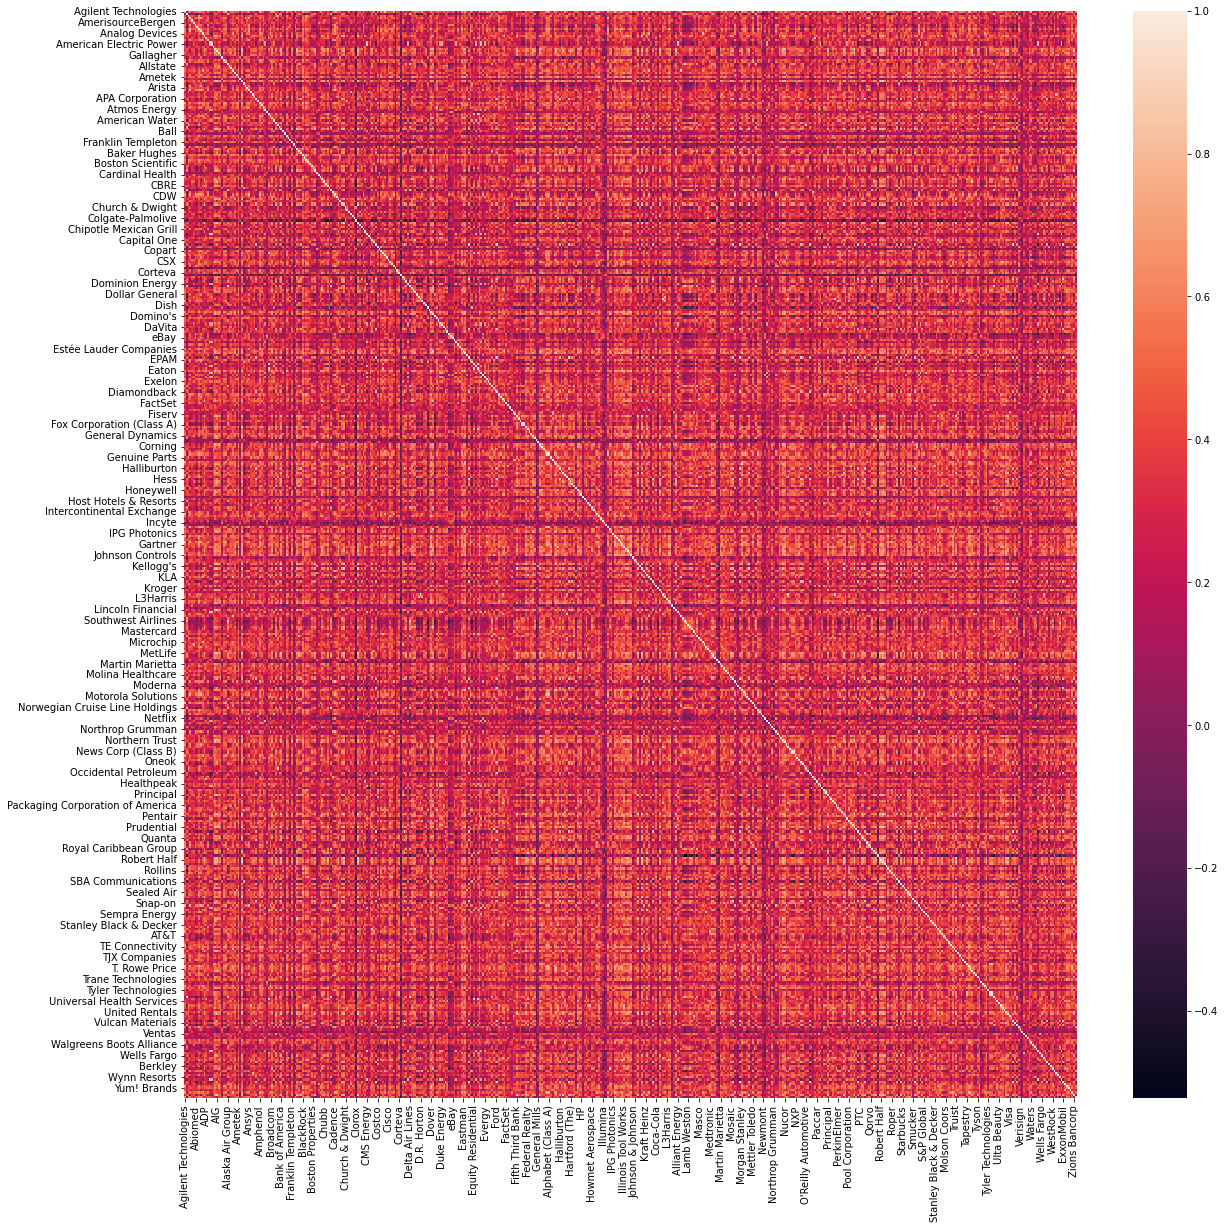

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_)

C:\Users\proma.gupta\Anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


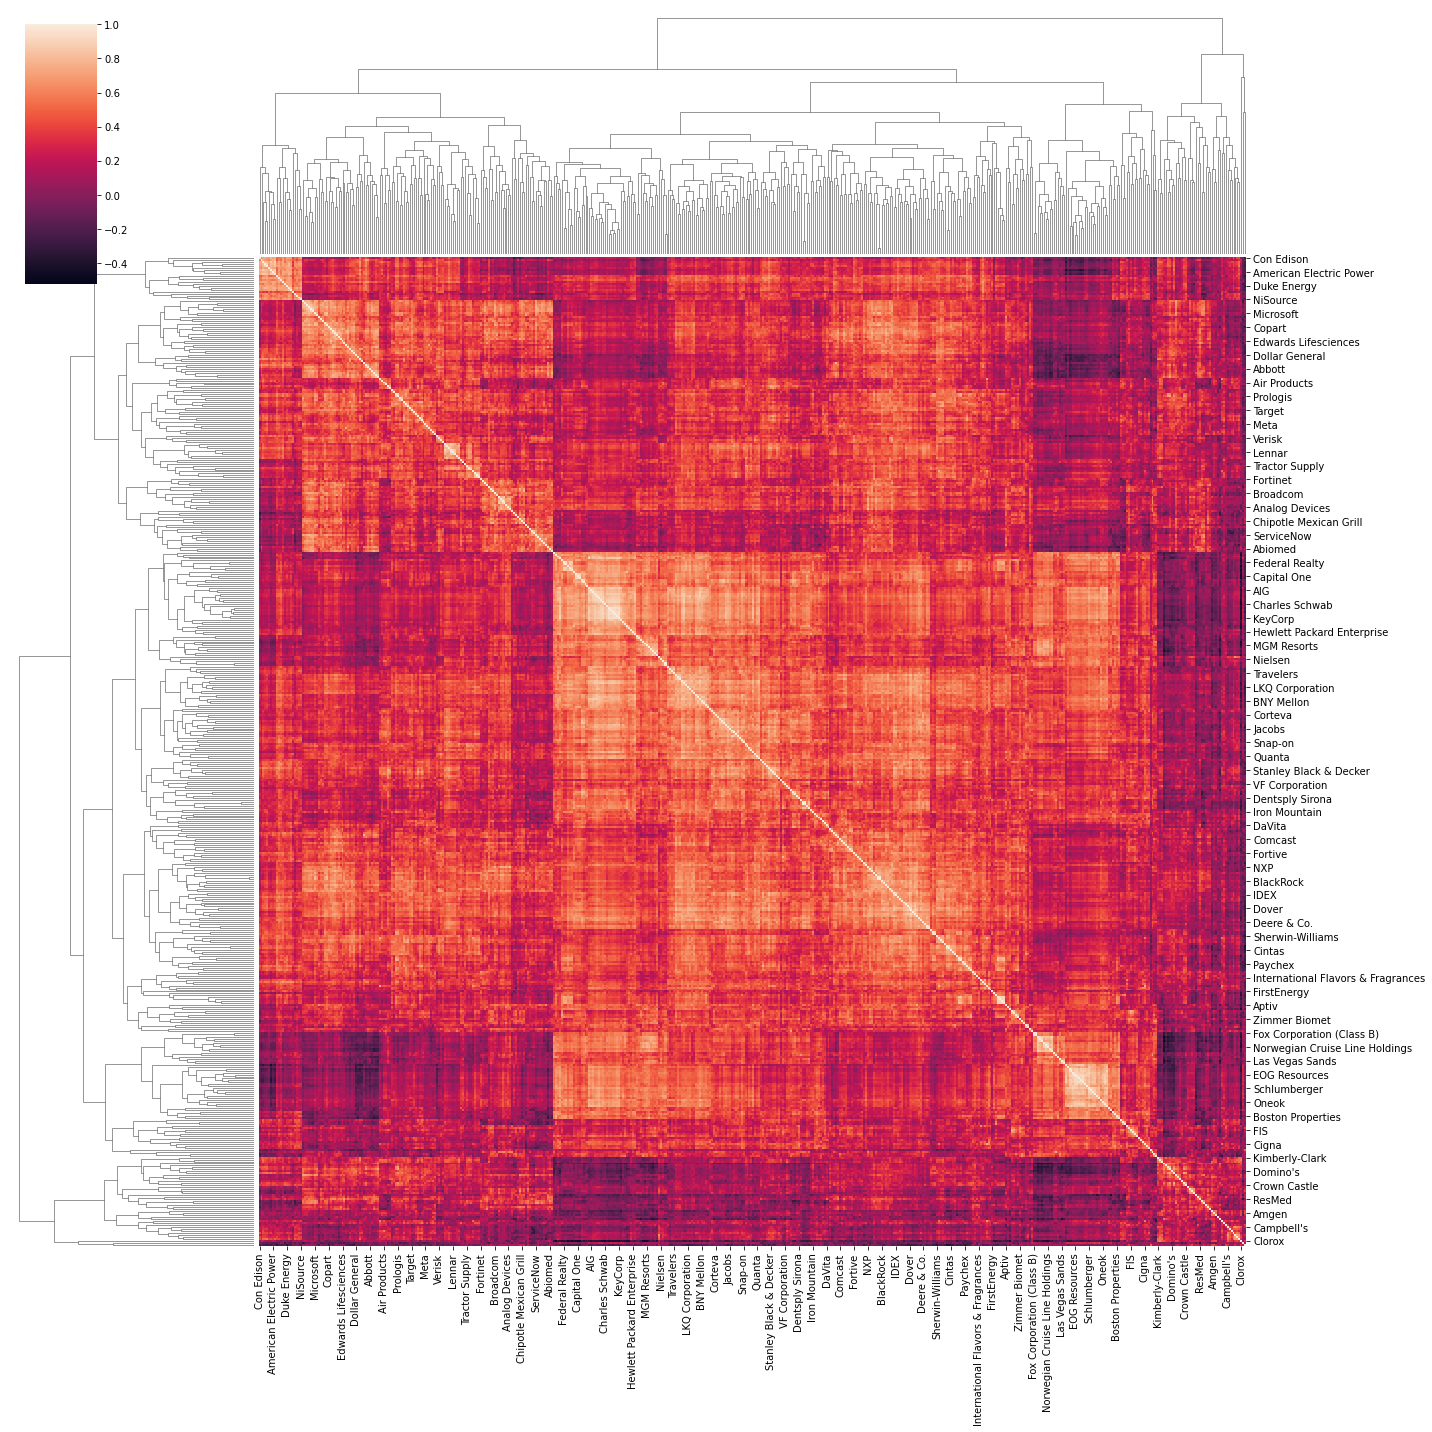

In [11]:
#The clustermap
sns.clustermap(corr_, figsize=(20,20))

In [13]:
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google.colab'

In [15]:
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_table = payload[0]
sp500_table

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
499,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
502,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [16]:
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values

sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("pastel", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("pastel", len(sp500_sub_sectors)).as_hex()))

In [17]:
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval='1d')
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)
prices

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- CEG: Data doesn't exist for startDate = 1577858400, endDate = 1640930400
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem,Yum! Brands,Zimmer Biomet,Zebra,Zions Bancorp,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,84.666748,28.982893,154.629822,73.785912,79.461998,81.815147,168.809998,83.667686,203.171158,334.429993,...,142.405029,58.709503,60.554615,56.203197,77.520622,97.649078,142.509018,259.140015,48.681538,132.200867
2020-01-03,83.307358,27.548195,154.639526,73.068558,78.707741,80.786217,166.820007,82.647705,202.832764,331.809998,...,140.292755,58.991848,60.067799,55.581242,77.976913,97.343254,142.136505,256.049988,47.994579,132.220566
2020-01-06,83.553619,27.219410,152.098083,73.650787,79.328888,81.969002,179.039993,83.080719,201.508240,333.709991,...,140.015091,58.907146,60.528996,55.887280,77.472076,97.285904,141.315063,258.010010,47.409729,131.205444
2020-01-07,83.809731,27.119778,150.293854,73.304413,78.876350,81.382423,180.350006,82.618835,197.157684,333.390015,...,140.679504,58.784794,60.033630,56.183449,77.180832,97.457939,141.190887,256.470001,47.121941,131.648941
2020-01-08,84.637192,27.737495,148.567245,74.483620,79.435364,82.170944,178.690002,82.955612,197.544403,337.869995,...,141.562103,58.728317,59.128300,56.775787,77.442963,97.629974,142.881531,247.639999,47.586109,131.363144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.282700,18.170000,234.790527,179.836319,131.908493,131.072433,357.829987,140.403183,413.026154,577.679993,...,87.580002,66.356621,60.590763,55.950001,117.468552,136.694839,123.849663,606.330017,62.253880,245.684570
2021-12-28,158.721420,18.540001,236.408752,178.799149,131.888855,131.529556,357.440002,139.420593,412.966461,569.359985,...,86.459999,67.151077,60.394962,56.029999,118.690010,136.665131,124.237274,597.320007,62.352680,243.432159
2021-12-29,160.187180,18.049999,239.287781,178.888916,132.840790,132.503387,361.839996,140.135193,413.115692,569.289978,...,84.980003,67.488716,59.866302,56.650002,118.531120,137.338654,124.256653,601.119995,62.688602,246.202835


In [18]:
for i, row in prices.iterrows():
  if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')
print(prices.shape)

(504, 500)


In [19]:
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_)

In [20]:
threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False, orientation='horizontal',
                           layout=Layout(width='500px'), style=dict(description_width= 'initial'))

network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='MediumPurple',width=10),
                                           marker=dict(size=20, line_width=10,line=dict(color='MediumPurple',width=2))),
                                go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", 
                                          text=[],hoverinfo='text',textfont_size=12, marker=dict(size=50, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))
df = prices.copy()
correlation_matrix = corr_.to_numpy()


def plot_corr_graph(change):
    threshold, corr_mode = None, None

    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0

    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)

    remove = []
    
    for col1, col2, weight in G.edges(data=True):

        if math.isnan(weight["weight"]):
            remove.append((col1,col2))
    
        if abs(weight["weight"]) < threshold:
            remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))

    for node in G.nodes:
        if node not in edges:
            remove.append(node)

    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)

    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]

    # def assign_thickness(correlation, benchmark_thickness=20, scaling_factor=2):
    #   return benchmark_thickness * abs(correlation)**scaling_factor

    # def assign_node_size(degree, scaling_factor=500):
    #   return degree * scaling_factor

    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"

    edge_colors = []
    # edge_width = []
    # node_size = []
    node_colors = []

    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
        # edge_width.append(assign_thickness(value))

    for key, value in dict(mst.degree).items():
        # node_size.append(assign_node_size(value))
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
    # annotations_list =[dict(x=weight[1], y=weight[2], xref='x', yref='y', text=weight[0], ax=weight[1], ay=weight[2]) for weight in weights]
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
        # network.update_layout(annotations=annotations_list)
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice])

In [21]:
network

FigureWidget({
    'data': [{'line': {'color': 'MediumPurple', 'width': 10},
              'marker': {'line': …

In [23]:
threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice>0.70])

TypeError: '>' not supported between instances of 'FloatSlider' and 'float'

In [24]:
https://medium.com/@kenanekici/visualizing-multicollinearity-in-python-b5feedc9b3f1

SyntaxError: invalid syntax (Temp/ipykernel_22492/1703698960.py, line 1)